# Fine-tuning the BCI for all locations

### 1) Needed to improve visualization of the BCI plot by log-scaling the x-axis
### 2) Took notes on thresholds and used the misassigned points to find the ideal threshold for all locations.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import sys
sys.path.append("../src")

from core import SITE_NAMES
import bout_clustering as bt_clustering
import bout_plotting as bt_plt

In [2]:
site_key = 'Central'
freq_key = 'hf_'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000

print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


In [3]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_loc, hist_loc = bt_clustering.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)

fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)
slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = bt_clustering.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 542152223 missassigned points
Slater method has 896370 missassigned points
Sibly method has 881153 missassigned points
Optim BCI has less misassignments than BCI? True
15216 more points assigned correctly


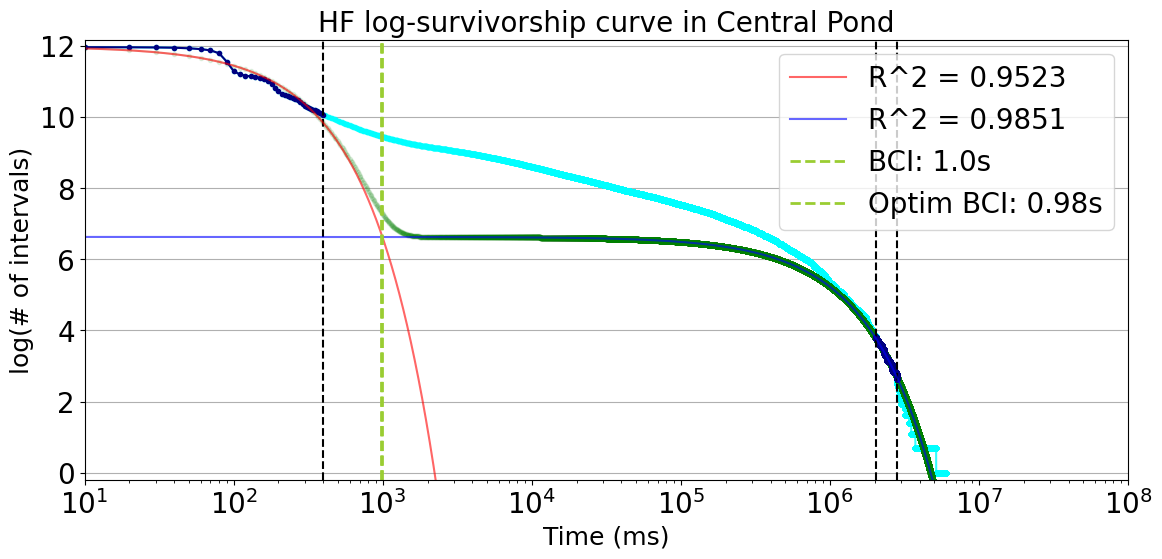

In [4]:
fig_details['time_end'] = 60000
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

## The slow processes were estimated as the intervals where survival was within 30% and 40% of its maximum value

In [17]:
def regress_around_slow_intervals(intervals_ms, survival):
    """
    Use scipy.stats to compute linear regression coefficients around points
    we associate with between-bout intervals.

    These interval points to regress around are chosen using values between 30-40% of the max survival.
    We have observed that these points have a strong linear relationship.
    They are also among intervals from 20 to 60min. This range is very likely between-bout.
    """

    slow_inds = np.logical_and(survival >= (survival.max() * 0.30), survival <= (survival.max() * 0.40)) 
    slow_coeff = stats.linregress(intervals_ms[slow_inds], survival[slow_inds])

    slow_process = dict()
    slow_process['metrics'] = slow_coeff
    slow_process['indices'] = slow_inds
    return slow_process

In [18]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_loc, hist_loc = bt_clustering.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)

fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)
slow_process = regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = bt_clustering.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_21763/1843924586.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)


Fagen&Young method has 1169780052 missassigned points
Slater method has 1166282 missassigned points
Sibly method has 1160384 missassigned points
Optim BCI has less misassignments than BCI? True
5898 more points assigned correctly


## This led to 1160384 misassigned points for Foliage HF calls using the Sibly method.
### If we tracked the # of misassigned points and adjusted the thresholds, we could get fine-tune the BCI to capture the least misassigned events

### Below, I tested several threshold variations and tracked the misassignments for each frequency group in Central Pond and Foliage.

- 30% - 40% -> misassigned points: 1168593 (central hf), 1435783 (foliage lf), 936154 (central lf), 1160384 (foliage hf)
- 25% - 40% -> misassigned points: 1115471 (central hf), 1419923 (foliage lf), 910232 (central lf), 1137969 (foliage hf)
- 22% - 40% -> misassigned points: 1088816 (central hf), 1274986 (foliage lf), 947709 (central lf), 1126713 (foliage hf)

- 25% - 50% -> misassigned points: 1133561 (central hf), 1664040 (foliage lf), 1236618 (central lf), 1508218 (foliage hf)
- 22% - 50% -> misassigned points: 1120225 (central hf), 1547889 (foliage lf), 1195551 (central lf), 1475025 (foliage hf)

- 30% - 31% -> misassigned points: 675071 (central hf), 625668 (foliage lf), 322653 (central lf), 1278097 (foliage hf)
- 22% - 30% -> misassigned points: 872440 (central hf), 818915 (foliage lf), 1193641 (central lf), 798015 (foliage hf)
- 22% - 32% -> misassigned points: 881153 (central hf), 965571 (foliage lf), 1044611 (central lf), 900069 (foliage hf)

### The final implementation will thus use 22% - 32% of the survival's max values for estimating slow processes

In [ ]:
def regress_around_slow_intervals(intervals_ms, survival):
    """
    Use scipy.stats to compute linear regression coefficients around points
    we associate with between-bout intervals.

    These interval points to regress around are chosen using values between 30-40% of the max survival.
    We have observed that these points have a strong linear relationship.
    They are also among intervals from 20 to 60min. This range is very likely between-bout.
    """

    slow_inds = np.logical_and(survival >= (survival.max() * 0.22), survival <= (survival.max() * 0.32)) 
    slow_coeff = stats.linregress(intervals_ms[slow_inds], survival[slow_inds])

    slow_process = dict()
    slow_process['metrics'] = slow_coeff
    slow_process['indices'] = slow_inds
    return slow_process